In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pytensor
import warnings

warnings.filterwarnings('ignore')

def run_joint_three_analysis(data_filename_q1, data_filename_q2, data_filename_order, results_filename="results_joint_three.pkl"):
    """
    Jointly analyzes three response types:
      - Q1 responses,
      - Q2 responses, and
      - the ordering decision (Q3; here output as EEG data).
    
    The model is specified as follows:
      For observation n (with expert i, case j, and occasion t):
      
      **Q1:**
         logit(P(Y_n = 1)) = intercept + c_j + l_{12,i} + p^{(1)}_{ij} + o_{ijt}
      
      **Q2:**
         logit(P(Y_n = 1)) = intercept + c_j + c2_j + l_{12,i} + p^{(2)}_{ij} + o_{ijt}
      
      **Q3 (ordering decision):**
         logit(P(Y_n = 1)) = intercept + c_j + l_{order,i} + p^{(3)}_{ij} + o_{ijt}
    
    Note: The observation noise o_{ijt} is modeled with a single scale across all responses.
    
    After sampling, latent effects are saved to three CSV files:
      - dataQ1_latent_effects.csv
      - dataQ2_latent_effects.csv
      - dataEEG_latent_effects.csv
      
    Parameters:
      data_filename_q1: CSV file with Q1 responses.
      data_filename_q2: CSV file with Q2 responses.
      data_filename_order: CSV file with ordering decision responses.
      results_filename: Filename to save the results dictionary.
    """
    # Set PyTensor flags.
    os.environ["PYTENSOR_DEVICE"] = "cpu"
    os.environ["PYTENSOR_FLOATX"] = "float64"
    os.environ["PYTENSOR_COMPUTE_TEST_VALUE"] = "ignore"
    
    # --- Load and combine the data ---
    print("Loading Q1 data from", data_filename_q1)
    data_q1 = pd.read_csv(data_filename_q1)
    data_q1["question"] = 1  # Mark Q1 responses

    print("Loading Q2 data from", data_filename_q2)
    data_q2 = pd.read_csv(data_filename_q2)
    data_q2["question"] = 2  # Mark Q2 responses

    print("Loading ordering decision data from", data_filename_order)
    data_order = pd.read_csv(data_filename_order)
    data_order["question"] = 3  # Mark ordering decision responses

    # Combine into one DataFrame.
    data = pd.concat([data_q1, data_q2, data_order], ignore_index=True)
    print("\nCombined data head:")
    print(data.head())
    
    # Create integer indices for experts, cases, and occasions.
    data['expert_idx'] = pd.Categorical(data['id']).codes
    data['case_idx'] = pd.Categorical(data['item']).codes
    data['occ_idx'] = pd.Categorical(data['t']).codes  # occasion-level index

    # Dimensions.
    n_experts = data['expert_idx'].nunique()
    n_cases   = data['case_idx'].nunique()
    n_obs     = data.shape[0]
    
    print("\nDataset summary (joint three-response model):")
    print(f"  Number of experts: {n_experts}")
    print(f"  Number of cases:   {n_cases}")
    print(f"  Number of observations: {n_obs}")
    
    # --- Build the joint model ---
    print("\nBuilding joint model for Q1, Q2, and ordering decision...")
    with pm.Model() as model:
        # Priors for scale parameters.
        sigma_c      = pm.HalfNormal("sigma_c", sigma=1)
        sigma_c2     = pm.HalfNormal("sigma_c2", sigma=1)  # extra Q2 signal
        sigma_l12    = pm.HalfNormal("sigma_l12", sigma=1) # for Q1 & Q2 expert tendency
        sigma_lorder = pm.HalfNormal("sigma_lorder", sigma=1) # for ordering decision expert tendency
        sigma_p1     = pm.HalfNormal("sigma_p1", sigma=1)    # interaction term for Q1
        sigma_p2     = pm.HalfNormal("sigma_p2", sigma=1)    # interaction term for Q2
        sigma_p3     = pm.HalfNormal("sigma_p3", sigma=1)    # interaction term for Q3 (ordering)
        sigma_o      = pm.HalfNormal("sigma_o", sigma=1)     # observation noise (common)
        intercept    = pm.Normal("intercept", mu=0, sigma=10)
        
        # Non-centered parameterizations.
        z_c = pm.Normal("z_c", mu=0, sigma=1, shape=n_cases)
        c = pm.Deterministic("c", z_c * sigma_c)
        
        z_c2 = pm.Normal("z_c2", mu=0, sigma=1, shape=n_cases)
        c2 = pm.Deterministic("c2", z_c2 * sigma_c2)
        
        z_l12 = pm.Normal("z_l12", mu=0, sigma=1, shape=n_experts)
        l12 = pm.Deterministic("l12", z_l12 * sigma_l12)
        
        z_lorder = pm.Normal("z_lorder", mu=0, sigma=1, shape=n_experts)
        lorder = pm.Deterministic("lorder", z_lorder * sigma_lorder)
        
        z_p1 = pm.Normal("z_p1", mu=0, sigma=1, shape=(n_experts, n_cases))
        p1 = pm.Deterministic("p1", z_p1 * sigma_p1)
        
        z_p2 = pm.Normal("z_p2", mu=0, sigma=1, shape=(n_experts, n_cases))
        p2 = pm.Deterministic("p2", z_p2 * sigma_p2)
        
        z_p3 = pm.Normal("z_p3", mu=0, sigma=1, shape=(n_experts, n_cases))
        p3 = pm.Deterministic("p3", z_p3 * sigma_p3)
        
        z_o = pm.Normal("z_o", mu=0, sigma=1, shape=n_obs)
        o = pm.Deterministic("o", z_o * sigma_o)
        
        # Prepare indices and indicators.
        expert_idx = data['expert_idx'].values  # expert index for each observation
        case_idx   = data['case_idx'].values    # case index for each observation
        obs_idx    = np.arange(n_obs)            # observation index for o
        questions  = data['question'].values      # 1 for Q1, 2 for Q2, 3 for ordering
        
        # Indicators.
        indicator1 = (questions == 1).astype(float)
        indicator2 = (questions == 2).astype(float)
        indicator3 = (questions == 3).astype(float)
        
        # Expert-level parameter: use l12 for Q1 and Q2, lorder for Q3.
        l_val = (1 - indicator3) * l12[expert_idx] + indicator3 * lorder[expert_idx]
        
        # Interaction term: use the appropriate p for each response type.
        p_val = (indicator1 * p1[expert_idx, case_idx] +
                 indicator2 * p2[expert_idx, case_idx] +
                 indicator3 * p3[expert_idx, case_idx])
        
        # Linear predictor.
        # For Q2, add extra signal c2; otherwise, no extra case signal.
        z = (intercept +
             c[case_idx] +
             indicator2 * c2[case_idx] +
             l_val +
             p_val +
             o[obs_idx])
        
        # Likelihood.
        y_obs = pm.Bernoulli("y_obs", logit_p=z, observed=data['Y'].values)
        
        # Specify only the key variables you want to monitor to reduce memory usage.
        monitor_vars = ['sigma_c', 'sigma_c2', 'sigma_l12', 'sigma_lorder', 
                        'sigma_p1', 'sigma_p2', 'sigma_p3', 'sigma_o', 'intercept',
                        'c', 'c2', 'l12', 'lorder', 'p1', 'p2', 'p3', 'o']
        
        print("\nSampling joint model...")
        trace = pm.sample(
            draws=4000,
            tune=1000,
            chains=8,
            cores=6,
            random_seed=42,
            return_inferencedata=True,
            nuts_sampler='numpyro',
            init='jitter+adapt_diag',
            progressbar=True,
            target_accept=0.98,
            var_names=monitor_vars  # Only store specified variables.
        )
    
    # --- Post-sampling analysis ---
    print("\nPosterior Summary (joint three-response model):")
    summary = az.summary(trace, var_names=monitor_vars)
    print(summary)
    
    # Compute effective scales (using sigma parameters).
    sigma_c_samples      = trace.posterior['sigma_c'].values.flatten()
    sigma_c2_samples     = trace.posterior['sigma_c2'].values.flatten()
    sigma_l12_samples    = trace.posterior['sigma_l12'].values.flatten()
    sigma_lorder_samples = trace.posterior['sigma_lorder'].values.flatten()
    sigma_p1_samples     = trace.posterior['sigma_p1'].values.flatten()
    sigma_p2_samples     = trace.posterior['sigma_p2'].values.flatten()
    sigma_p3_samples     = trace.posterior['sigma_p3'].values.flatten()
    sigma_o_samples      = trace.posterior['sigma_o'].values.flatten()
    
    var_c      = np.mean(sigma_c_samples ** 2)
    var_c2     = np.mean(sigma_c2_samples ** 2)
    var_l12    = np.mean(sigma_l12_samples ** 2)
    var_lorder = np.mean(sigma_lorder_samples ** 2)
    var_p1     = np.mean(sigma_p1_samples ** 2)
    var_p2     = np.mean(sigma_p2_samples ** 2)
    var_p3     = np.mean(sigma_p3_samples ** 2)
    var_o      = np.mean(sigma_o_samples ** 2)
    
    print("\nEffective scale estimates:")
    print(f"  Common case signal (S):        {np.sqrt(var_c):.2f}")
    print(f"  Extra Q2 signal (S2):          {np.sqrt(var_c2):.2f}")
    print(f"  Expert tendency (Q1 & Q2, LN12): {np.sqrt(var_l12):.2f}")
    print(f"  Expert tendency (ordering, LNorder): {np.sqrt(var_lorder):.2f}")
    print(f"  Interaction Q1 (PN1):          {np.sqrt(var_p1):.2f}")
    print(f"  Interaction Q2 (PN2):          {np.sqrt(var_p2):.2f}")
    print(f"  Interaction Q3 (PN3):          {np.sqrt(var_p3):.2f}")
    print(f"  Observation noise (ON):        {np.sqrt(var_o):.2f}")
    
    # --- Extract latent effects and write CSV files ---
    # Extract posterior means.
    c_est      = trace.posterior['c'].mean(dim=["chain", "draw"]).values    # shape: (n_cases,)
    c2_est     = trace.posterior['c2'].mean(dim=["chain", "draw"]).values   # shape: (n_cases,)
    l12_est    = trace.posterior['l12'].mean(dim=["chain", "draw"]).values    # shape: (n_experts,)
    lorder_est = trace.posterior['lorder'].mean(dim=["chain", "draw"]).values # shape: (n_experts,)
    p1_est     = trace.posterior['p1'].mean(dim=["chain", "draw"]).values     # shape: (n_experts, n_cases)
    p2_est     = trace.posterior['p2'].mean(dim=["chain", "draw"]).values     # shape: (n_experts, n_cases)
    p3_est     = trace.posterior['p3'].mean(dim=["chain", "draw"]).values     # shape: (n_experts, n_cases)
    o_est      = trace.posterior['o'].mean(dim=["chain", "draw"]).values      # shape: (n_obs,)
    
    # Create a DataFrame with latent effects.
    df_latents = data[['expert_idx', 'case_idx', 'occ_idx', 'question']].copy()
    df_latents['c'] = df_latents['case_idx'].apply(lambda j: c_est[int(j)])
    df_latents['c2'] = df_latents['case_idx'].apply(lambda j: c2_est[int(j)])
    df_latents['l'] = df_latents.apply(lambda row: lorder_est[int(row['expert_idx'])] 
                                       if row['question'] == 3 
                                       else l12_est[int(row['expert_idx'])], axis=1)
    df_latents['p'] = df_latents.apply(lambda row: 
                                       p1_est[int(row['expert_idx']), int(row['case_idx'])] if row['question'] == 1 
                                       else (p2_est[int(row['expert_idx']), int(row['case_idx'])] if row['question'] == 2 
                                             else p3_est[int(row['expert_idx']), int(row['case_idx'])]),
                                       axis=1)
    # The observation-level effect is unique to each observation.
    df_latents['o'] = o_est
    
    # Optionally, rename index columns.
    df_latents.rename(columns={"expert_idx": "i", "case_idx": "j", "occ_idx": "t"}, inplace=True)
    
    # Split the DataFrame by question and write to CSV files.
    df_Q1 = df_latents[df_latents['question'] == 1]
    df_Q2 = df_latents[df_latents['question'] == 2]
    df_Q3 = df_latents[df_latents['question'] == 3]
    
    q1_filename = "dataQ1_latent_effects.csv"
    q2_filename = "dataQ2_latent_effects.csv"
    eeg_filename = "dataEEG_latent_effects.csv"  # for ordering decision
    
    df_Q1.to_csv(q1_filename, index=False)
    print("Estimated random effects for Q1 saved to", q1_filename)
    
    df_Q2.to_csv(q2_filename, index=False)
    print("Estimated random effects for Q2 saved to", q2_filename)
    
    df_Q3.to_csv(eeg_filename, index=False)
    print("Estimated random effects for ordering decision saved to", eeg_filename)
    
    # Prepare results dictionary.
    results = {
        "trace": trace,
        "effective_scales": {
            "S": np.sqrt(var_c),
            "S2": np.sqrt(var_c2),
            "LN12": np.sqrt(var_l12),
            "LNorder": np.sqrt(var_lorder),
            "PN1": np.sqrt(var_p1),
            "PN2": np.sqrt(var_p2),
            "PN3": np.sqrt(var_p3),
            "ON": np.sqrt(var_o)
        },
        "data": data
    }
    
    # (Optional) Save results to a file.
    # with open(results_filename, "wb") as f:
    #     pickle.dump(results, f)
    # print(f"\nResults saved to {results_filename}")
    
    return results

# Example call:
results_joint_three = run_joint_three_analysis("dataQ1.csv", "dataQ2.csv", "dataQEEG.csv", "results_joint_three.pkl")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Loading Q1 data from dataQ1.csv
Loading Q2 data from dataQ2.csv
Loading ordering decision data from dataQEEG.csv

Combined data head:
   id  item  t  Y  question
0   1     1  1  0         1
1   1     2  1  0         1
2   1     3  1  0         1
3   1     4  1  0         1
4   1     5  1  1         1

Dataset summary (joint three-response model):
  Number of experts: 20
  Number of cases:   50
  Number of observations: 6000

Building joint model for Q1, Q2, and ordering decision...

Sampling joint model...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


Posterior Summary (joint three-response model):
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_c       1.657  0.199   1.296    2.034      0.002    0.001   12322.0   
sigma_c2      3.443  0.346   2.813    4.104      0.003    0.002   15133.0   
sigma_l12     0.880  0.190   0.553    1.227      0.002    0.001   11067.0   
sigma_lorder  4.000  0.439   3.191    4.831      0.004    0.003   13072.0   
sigma_p1      0.315  0.212   0.000    0.680      0.003    0.002    5104.0   
...             ...    ...     ...      ...        ...      ...       ...   
o[5995]       0.007  0.245  -0.481    0.499      0.001    0.002   73234.0   
o[5996]       0.031  0.241  -0.436    0.520      0.001    0.002   60984.0   
o[5997]       0.034  0.245  -0.457    0.528      0.001    0.002   55987.0   
o[5998]      -0.003  0.244  -0.506    0.469      0.001    0.002   82449.0   
o[5999]      -0.029  0.239  -0.539    0.418      0.001    0.002   61068.0   

              ess_tail  r_

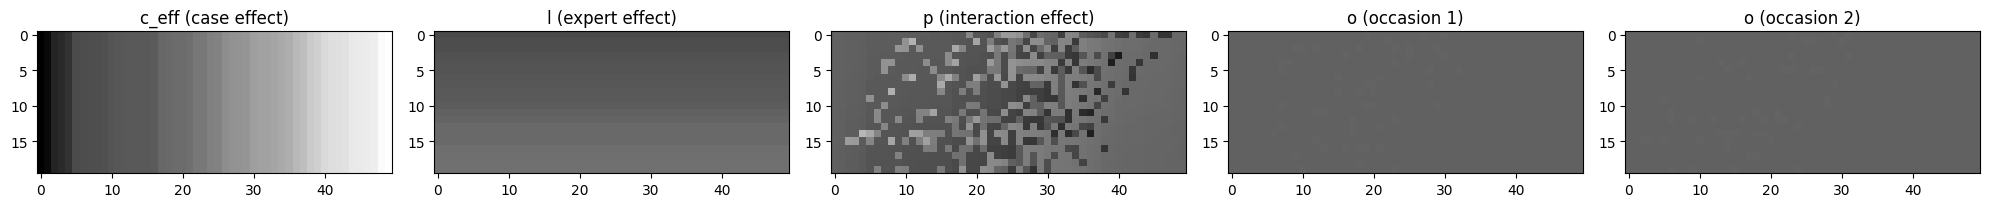

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load CSV and prepare pivot tables
# -----------------------------
df = pd.read_csv("dataQ2_latent_effects.csv")

# Ensure the index columns are integers.
df['i'] = df['i'].astype(int)
df['j'] = df['j'].astype(int)
df['t'] = df['t'].astype(int)

# For Q2, compute the effective case effect as the sum of the common case signal and the extra Q2 signal.
df['c_eff'] = df['c'] + df['c2']

# Create pivot tables (20 x 50 matrices) for each latent effect.
# For the case effect, use the effective case signal (c_eff).
df_c  = df.pivot_table(index='i', columns='j', values='c_eff', aggfunc='first')
df_l  = df.pivot_table(index='i', columns='j', values='l', aggfunc='first')
df_p  = df.pivot_table(index='i', columns='j', values='p', aggfunc='first')
df_o1 = df[df['t'] == 0].pivot_table(index='i', columns='j', values='o', aggfunc='first')
df_o2 = df[df['t'] == 1].pivot_table(index='i', columns='j', values='o', aggfunc='first')

# -----------------------------
# Sorting: sort rows (i) by expert latent (l) and columns (j) by case latent (c_eff)
# -----------------------------
# For experts, l is constant across cases so we use the first column.
expert_order = df_l.iloc[:, 0].sort_values().index
# For cases, c_eff is constant across experts so we use the first row.
case_order   = df_c.iloc[0].sort_values().index

# Reindex all matrices using the determined order.
df_c  = df_c.reindex(index=expert_order, columns=case_order)
df_l  = df_l.reindex(index=expert_order, columns=case_order)
df_p  = df_p.reindex(index=expert_order, columns=case_order)
df_o1 = df_o1.reindex(index=expert_order, columns=case_order)
df_o2 = df_o2.reindex(index=expert_order, columns=case_order)

# -----------------------------
# Determine global min and max across all matrices for consistent grayscale scaling.
# -----------------------------
global_min = min(df_c.min().min(), df_l.min().min(), df_p.min().min(), 
                 df_o1.min().min(), df_o2.min().min())
global_max = max(df_c.max().max(), df_l.max().max(), df_p.max().max(), 
                 df_o1.max().max(), df_o2.max().max())

# -----------------------------
# Preview: Plot all 5 matrices side by side
# -----------------------------
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

axs[0].imshow(df_c.values, cmap="gray", vmin=global_min, vmax=global_max,
              aspect='equal', interpolation='none')
axs[0].set_title("c_eff (case effect)")

axs[1].imshow(df_l.values, cmap="gray", vmin=global_min, vmax=global_max,
              aspect='equal', interpolation='none')
axs[1].set_title("l (expert effect)")

axs[2].imshow(df_p.values, cmap="gray", vmin=global_min, vmax=global_max,
              aspect='equal', interpolation='none')
axs[2].set_title("p (interaction effect)")

axs[3].imshow(df_o1.values, cmap="gray", vmin=global_min, vmax=global_max,
              aspect='equal', interpolation='none')
axs[3].set_title("o (occasion 1)")

axs[4].imshow(df_o2.values, cmap="gray", vmin=global_min, vmax=global_max,
              aspect='equal', interpolation='none')
axs[4].set_title("o (occasion 2)")

plt.tight_layout()
plt.show()

# -----------------------------
# Save each matrix as an individual PNG file.
# Each file will have:
#  - No title or axes
#  - No extra white space (using tight layout options)
#  - 300 dpi resolution
# -----------------------------
# Dictionary mapping filename to the corresponding matrix values.
matrices = {
    "matrix_c.png":  df_c.values,
    "matrix_l.png":  df_l.values,
    "matrix_p.png":  df_p.values,
    "matrix_o1.png": df_o1.values,
    "matrix_o2.png": df_o2.values,
}

# Loop over each matrix, create a figure, remove axes and whitespace, and save.
for fname, mat in matrices.items():
    # Set figure size to approximate the 20x50 (aspect ratio 2.5:1)
    fig, ax = plt.subplots(figsize=(5, 2))
    ax.imshow(mat, cmap="gray", vmin=global_min, vmax=global_max,
              aspect='equal', interpolation='none')
    ax.axis('off')  # remove axes
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(fname, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()


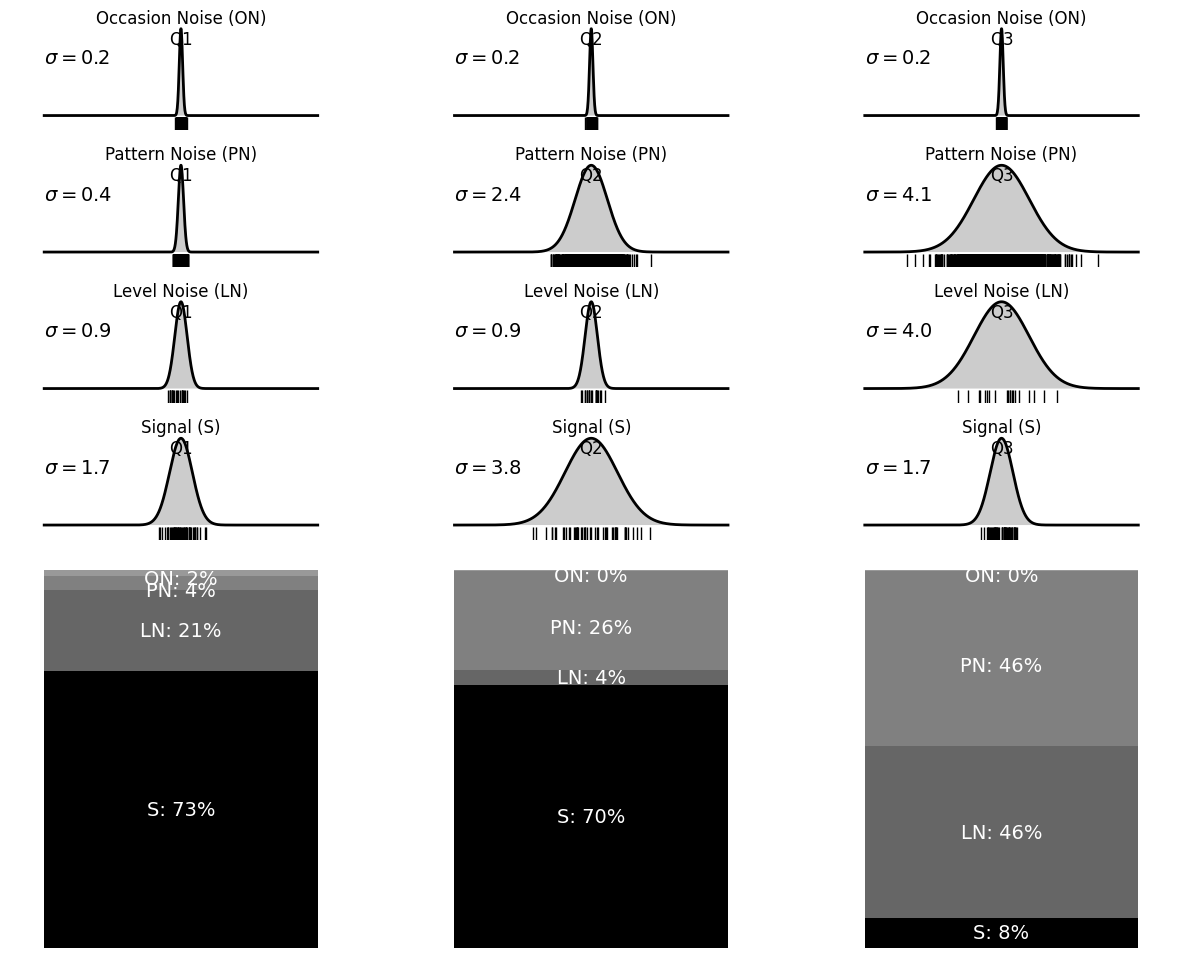

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as st

#--------------------------------------------------
# Helper Function: fcn_gaussian_plot (mimicking MATLAB)
#--------------------------------------------------
def fcn_gaussian_plot(ax, x, s, titleStr):
    xx = np.linspace(-20, 20, 1000)
    y = st.norm.pdf(xx, loc=0, scale=s)
    y = y / np.max(y)
    ax.plot(x, np.full_like(x, -0.1), 'k|', markersize=10)
    ax.fill_between(xx, 0, y, color=[0.8, 0.8, 0.8], edgecolor='none')
    ax.plot(xx, y, 'k', linewidth=2)
    ax.text(-20, 0.6, f"$\\sigma = {s:.1f}$", fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.set_title(titleStr, y=0.73)
    ax.set_xlim([-25, 25])

#--------------------------------------------------
# Helper Function: fcn_plot_stacked_bars_percent
#--------------------------------------------------
def fcn_plot_stacked_bars_percent(ax, perc_array, labels=None, on_offset=1):
    if labels is None:
        labels = ['S', 'LN', 'PN', 'ON']
    cc = np.array([[0, 0, 0],
                   [0.4, 0.4, 0.4],
                   [0.5, 0.5, 0.5],
                   [0.6, 0.6, 0.6]])
    cumsum_vals = np.cumsum(perc_array)
    prev = 0
    for i, val in enumerate(perc_array):
        mid = (prev + cumsum_vals[i]) / 2
        if i == len(perc_array) - 1:
            mid = mid - 1.5
        if i == len(perc_array) - 2:
            mid = mid - 2
        ax.bar(0, val, bottom=prev, color=cc[i], width=0.8, edgecolor='none')
        ax.text(0, mid, f"{labels[i]}: {val:.0f}%", ha='center', va='center', color='white', fontsize=14)
        prev = cumsum_vals[i]
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0, 100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

#--------------------------------------------------
# Plotting for all three sets of results
#--------------------------------------------------

# If you have a single joint results dictionary, define these as:
results1 = results2 = results3 = results_joint_three
results_list = [results1, results2, results3]
titles = ["Q1", "Q2", "Q3"]

fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(7, 3, figure=fig, hspace=0.3)

for col, (res, col_title) in enumerate(zip(results_list, titles)):
    trace = res["trace"]
    
    # Choose sigma values based on question
    if col == 0:  # Q1
        sigma_s_samples = trace.posterior['sigma_c'].values.flatten()
        sigma_l_samples = trace.posterior['sigma_l12'].values.flatten()
        sigma_p_samples = trace.posterior['sigma_p1'].values.flatten()
        sigma_o_samples = trace.posterior['sigma_o'].values.flatten()
    elif col == 1:  # Q2
        sigma_c_samples = trace.posterior['sigma_c'].values.flatten()
        sigma_c2_samples = trace.posterior['sigma_c2'].values.flatten()
        sigma_s_samples = np.sqrt(sigma_c_samples**2 + sigma_c2_samples**2)
        sigma_l_samples = trace.posterior['sigma_l12'].values.flatten()
        sigma_p_samples = trace.posterior['sigma_p2'].values.flatten()
        sigma_o_samples = trace.posterior['sigma_o'].values.flatten()
    elif col == 2:  # Q3
        sigma_s_samples = trace.posterior['sigma_c'].values.flatten()
        sigma_l_samples = trace.posterior['sigma_lorder'].values.flatten()
        sigma_p_samples = trace.posterior['sigma_p3'].values.flatten()
        sigma_o_samples = trace.posterior['sigma_o'].values.flatten()
    
    var_s = np.mean(sigma_s_samples ** 2)
    var_l = np.mean(sigma_l_samples ** 2)
    var_p = np.mean(sigma_p_samples ** 2)
    var_o = np.mean(sigma_o_samples ** 2)
    total_variance = var_s + var_l + var_p + var_o
    perc_s = (var_s / total_variance) * 100
    perc_l = (var_l / total_variance) * 100
    perc_p = (var_p / total_variance) * 100
    perc_o = (var_o / total_variance) * 100
    S_est = np.sqrt(var_s)
    LN_est = np.sqrt(var_l)
    PN_est = np.sqrt(var_p)
    ON_est = np.sqrt(var_o)
    
    ax1 = fig.add_subplot(gs[0, col])
    x_on = np.random.randn(50 * 20) * ON_est
    fcn_gaussian_plot(ax1, x_on, ON_est, f"Occasion Noise (ON)\n{col_title}")
    
    ax2 = fig.add_subplot(gs[1, col])
    x_pn = np.random.randn(20 * 50) * PN_est
    fcn_gaussian_plot(ax2, x_pn, PN_est, f"Pattern Noise (PN)\n{col_title}")
    
    ax3 = fig.add_subplot(gs[2, col])
    x_ln = np.random.randn(20) * LN_est
    fcn_gaussian_plot(ax3, x_ln, LN_est, f"Level Noise (LN)\n{col_title}")
    
    ax4 = fig.add_subplot(gs[3, col])
    x_s = np.random.randn(50) * S_est
    fcn_gaussian_plot(ax4, x_s, S_est, f"Signal (S)\n{col_title}")
    
    ax5 = fig.add_subplot(gs[4:, col])
    perc_array = [perc_s, perc_l, perc_p, perc_o]
    fcn_plot_stacked_bars_percent(ax5, perc_array)

plt.tight_layout()
plt.savefig("publication_plot.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Helper: Compute percent agreement from percent yes.
# For each case, if p is the fraction of "1" responses, then agreement = max(p, 1-p).
# ------------------------------
def compute_agreement(p):
    return max(p, 1 - p)

# ------------------------------
# Process Q1
# ------------------------------

# Load raw responses for Q1 (expected columns: id, item, t, Y)
df_q1 = pd.read_csv('dataQ1.csv')

# Group raw responses by case (item) and compute percent yes.
q1_stats = df_q1.groupby('item')['Y'].mean().reset_index()
q1_stats.rename(columns={'Y': 'percent_yes'}, inplace=True)
q1_stats['percent_agreement'] = q1_stats['percent_yes'].apply(compute_agreement)

# Load latent effects for Q1 (expected columns: i, j, t, c, l, p, o)
latent_q1 = pd.read_csv('dataQ1_latent_effects.csv')
# Make sure the case indicator (j) is numeric.
latent_q1['j'] = pd.to_numeric(latent_q1['j'])

# Check raw "item" values.
raw_items = sorted(df_q1['item'].unique())
# Check latent items:
latent_items = sorted(latent_q1['j'].unique())

# If the raw data are 1-indexed (e.g. 1 to 50) and latent file is 0-indexed (e.g. 0 to 49),
# then adjust the latent file by adding 1.
if max(raw_items) == max(latent_items) + 1:
    print("Adjusting latent Q1 'j' values by adding 1 to match raw data items.")
    latent_q1['j'] = latent_q1['j'] + 1

# Now, extract exactly 50 values for c (signal strength) by grouping by "j"
# (assuming that each unique j corresponds to one case).
latent_q1_c = latent_q1.groupby('j')['c'].first().reset_index()
latent_q1_c.rename(columns={'j': 'item', 'c': 'signal'}, inplace=True)

# Ensure we have exactly 50 cases.
if latent_q1_c.shape[0] != 50:
    print(f"Warning: Expected 50 cases for Q1 latent signal but got {latent_q1_c.shape[0]}.")

# Merge the computed response stats with the latent signal.
q1_merged = pd.merge(q1_stats, latent_q1_c, on='item', how='inner')
# Sort by signal if desired.
q1_merged.sort_values('signal', inplace=True)

# ------------------------------
# Process Q2 (similarly)
# ------------------------------
df_q2 = pd.read_csv('dataQ2.csv')
q2_stats = df_q2.groupby('item')['Y'].mean().reset_index()
q2_stats.rename(columns={'Y': 'percent_yes'}, inplace=True)
q2_stats['percent_agreement'] = q2_stats['percent_yes'].apply(compute_agreement)

latent_q2 = pd.read_csv('dataQ2_latent_effects.csv')
latent_q2['j'] = pd.to_numeric(latent_q2['j'])
latent_items_q2 = sorted(latent_q2['j'].unique())
if max(raw_items) == max(latent_items_q2) + 1:
    print("Adjusting latent Q2 'j' values by adding 1 to match raw data items.")
    latent_q2['j'] = latent_q2['j'] + 1

latent_q2_c = latent_q2.groupby('j')['c'].first().reset_index()
latent_q2_c.rename(columns={'j': 'item', 'c': 'signal'}, inplace=True)
if latent_q2_c.shape[0] != 50:
    print(f"Warning: Expected 50 cases for Q2 latent signal but got {latent_q2_c.shape[0]}.")

q2_merged = pd.merge(q2_stats, latent_q2_c, on='item', how='inner')
q2_merged.sort_values('signal', inplace=True)

# ------------------------------
# Plotting
# ------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.patch.set_facecolor('w')

# Q1: Percent Yes vs. Signal
axs[0, 0].plot(q1_merged['signal'], q1_merged['percent_yes'], 'k+', markersize=8)
axs[0, 0].plot(q1_merged['signal'], q1_merged['percent_yes'], 'k--', linewidth=2)
axs[0, 0].set_xlabel('Signal')
axs[0, 0].set_ylabel('% Yes')
axs[0, 0].set_title('Q1: % Yes vs Signal')
axs[0, 0].grid(True)
axs[0, 0].axis([-4, 4, 0, 1])
axs[0, 0].plot([-4, 4], [0.5, 0.5], 'r--', linewidth=2)

# Q1: Percent Agreement vs. Signal
axs[1, 0].plot(q1_merged['signal'], q1_merged['percent_agreement'], 'k+', markersize=8)
axs[1, 0].plot(q1_merged['signal'], q1_merged['percent_agreement'], 'k--', linewidth=2)
axs[1, 0].set_xlabel('Signal')
axs[1, 0].set_ylabel('% Agreement')
axs[1, 0].set_title('Q1: % Agreement vs Signal')
axs[1, 0].grid(True)
axs[1, 0].axis([-4, 4, 0, 1])
axs[1, 0].plot([-4, 4], [0.5, 0.5], 'r--', linewidth=2)

# Q2: Percent Yes vs. Signal
axs[0, 1].plot(q2_merged['signal'], q2_merged['percent_yes'], 'k+', markersize=8)
axs[0, 1].plot(q2_merged['signal'], q2_merged['percent_yes'], 'k--', linewidth=2)
axs[0, 1].set_xlabel('Signal')
axs[0, 1].set_ylabel('% Yes')
axs[0, 1].set_title('Q2: % Yes vs Signal')
axs[0, 1].grid(True)
axs[0, 1].axis([-4, 4, 0, 1])
axs[0, 1].plot([-4, 4], [0.5, 0.5], 'r--', linewidth=2)

# Q2: Percent Agreement vs. Signal
axs[1, 1].plot(q2_merged['signal'], q2_merged['percent_agreement'], 'k+', markersize=8)
axs[1, 1].plot(q2_merged['signal'], q2_merged['percent_agreement'], 'k--', linewidth=2)
axs[1, 1].set_xlabel('Signal')
axs[1, 1].set_ylabel('% Agreement')
axs[1, 1].set_title('Q2: % Agreement vs Signal')
axs[1, 1].grid(True)
axs[1, 1].axis([-4, 4, 0, 1])
axs[1, 1].plot([-4, 4], [0.5, 0.5], 'r--', linewidth=2)

plt.tight_layout()
plt.show()
